In [1]:
from IPython.core.display import HTML
display(HTML('<style>.container { width:95% !important; } </style>'))

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer
from neural_exploration import *
from statistics import mean, pstdev
sns.set()

### Bandit settings

In [3]:
T = int(5e2)
n_arms = 4
n_features = 16
noise_std = 0.1

confidence_scaling_factor = noise_std

n_sim = 2

SEED = 42
np.random.seed(SEED)

### Neural network settings

In [4]:
p = 0.2
hidden_size = 64
n_layers = 4
epochs = 100
train_every = 10
confidence_scaling_factor = 1.0
use_cuda = False

In [8]:
### LINEAR REWARDS
### mean reward function
a = np.random.randn(n_features)
a /= np.linalg.norm(a, ord=2)
h = lambda x: 10*np.dot(a, x)
bandit = ContextualBandit(T, n_arms, n_features, h, noise_std=noise_std, seed=SEED)

# l_regrets = np.empty((n_sim, T))
# atimes = []
# for i in range(n_sim):
#     bandit.reset_rewards()
#     model = NeuralUCB(bandit,
#                       hidden_size=hidden_size,
#                       reg_factor=1.0,
#                       delta=0.1,
#                       confidence_scaling_factor=confidence_scaling_factor,
#                       training_window=100,
#                       p=p,
#                       learning_rate=0.01,
#                       epochs=epochs,
#                       train_every=train_every,
#                       n_layers=4,
#                       use_cuda=use_cuda
#                      )
        
#     start = timer()
#     model.run()
#     end = timer()
#     atimes.append(end-start)
#     l_regrets[i] = np.cumsum(model.regrets)

l_regrets = np.empty((n_sim, T))
btimes = []
for i in range(n_sim):
    bandit.reset_rewards()
    model = NeuralUCB(bandit,
                      hidden_size=hidden_size,
                      reg_factor=1.0,
                      delta=0.1,
                      confidence_scaling_factor=confidence_scaling_factor,
                      training_window=100,
                      p=p,
                      learning_rate=0.01,
                      epochs=epochs,
                      train_every=train_every,
                      n_layers=4,
                      use_cuda=use_cuda
                     )
        
    start = timer()
    model.run()
    end = timer()
    btimes.append(end-start)
    l_regrets[i] = np.cumsum(model.regrets)

100%|██████████| 500/500 [10:22<00:00,  1.25s/it, total regret=588, % optimal arm=48.20%] 


In [7]:
pstdev(btimes)

8.035329540492967

In [ ]:

### QUADRATIC REWARDS
### mean reward function
a = np.random.randn(n_features)
a /= np.linalg.norm(a, ord=2)
h = lambda x: 100*np.dot(a, x)**2
bandit = ContextualBandit(T, n_arms, n_features, h, noise_std=noise_std, seed=SEED)

q_regrets = np.empty((n_sim, T))
quadtimes =[]
for i in range(n_sim):
    bandit.reset_rewards()
    model = NeuralUCB(bandit,
                      hidden_size=hidden_size,
                      reg_factor=1.0,
                      delta=0.1,
                      confidence_scaling_factor=confidence_scaling_factor,
                      training_window=100,
                      p=p,
                      learning_rate=0.01,
                      epochs=epochs,
                      n_layers=n_layers,
                      train_every=train_every,
                      use_cuda=use_cuda,
                     )
    start = timer()
    model.run()
    end = timer()
    quadtimes.append(end-start)
    q_regrets[i] = np.cumsum(model.regrets)

### COSINE REWARDS
a = np.random.randn(n_features)
a /= np.linalg.norm(a, ord=2)
h = lambda x: np.cos(10*np.pi*np.dot(x, a))
bandit = ContextualBandit(T, n_arms, n_features, h, noise_std=noise_std, seed=SEED)

c_regrets = np.empty((n_sim, T))
costimes = []
for i in range(n_sim):
    bandit.reset_rewards()
    model = NeuralUCB(bandit,
                      hidden_size=hidden_size,
                      reg_factor=1.0,
                      delta=0.1,
                      confidence_scaling_factor=confidence_scaling_factor,
                      training_window=100,
                      p=p,
                      learning_rate=0.01,
                      n_layers=n_layers,
                      epochs=epochs,
                      train_every=train_every,
                      use_cuda=use_cuda,
                     )
    start = timer()
    model.run()
    end = timer()
    costimes.append(end-start)
    c_regrets[i] = np.cumsum(model.regrets)

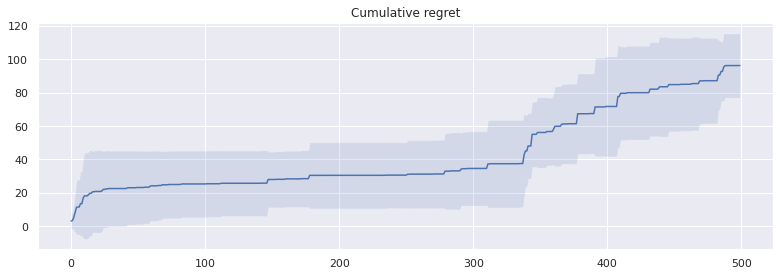

In [7]:
fig, ax = plt.subplots(figsize=(11, 4), nrows=1, ncols=1)

t = np.arange(T)

mean_lregrets = np.mean(l_regrets, axis=0)
std_lregrets = np.std(l_regrets, axis=0) / np.sqrt(l_regrets.shape[0])
ax.plot(t, mean_lregrets, label="Linear")

mean_qregrets = np.mean(q_regrets, axis=0)
ax.plot(t, mean_qregrets, label="Quadratic")

mean_cregrets = np.mean(c_regrets, axis=0)
ax.plot(t, mean_cregrets, label="Cosine")

mean_lregrets = np.mean(l_regrets, axis=0)
std_lregrets = np.std(l_regrets, axis=0) / np.sqrt(l_regrets.shape[0])
ax.plot(t, mean_l_regrets, label="Linear")

ax.set_title('Cumulative Regret')

plt.tight_layout()
plt.show()

fig.savefig('figures/neural_ucb_linear.pdf')

### NeuralUCB on quadratic rewards

### Sublinear regret growth : the bandit problem is solved efficiently (even though the reward is nonlinear!)

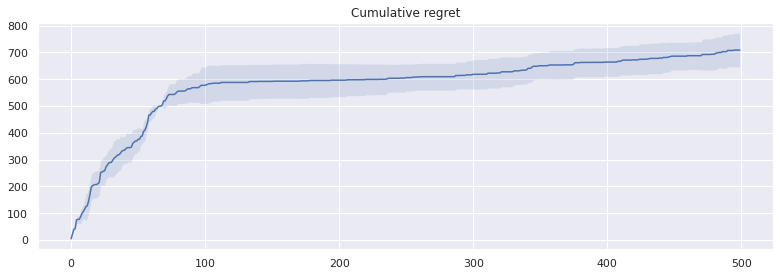

In [10]:
fig, ax = plt.subplots(figsize=(11, 4), nrows=1, ncols=1)

t = np.arange(T)

mean_regrets = np.mean(regrets, axis=0)
std_regrets = np.std(regrets, axis=0) / np.sqrt(regrets.shape[0])
ax.plot(t, mean_regrets)
ax.fill_between(t, mean_regrets - 2*std_regrets, mean_regrets + 2*std_regrets, alpha=0.15)
    
ax.set_title('Cumulative regret')

plt.tight_layout()
plt.show()

fig.savefig('figures/neural_ucb_quad.pdf')

### NeuralUCB on nonlinear rewards

### Sublinear regret growth : the bandit problem is solved efficiently (even though the reward is nonlinear!)

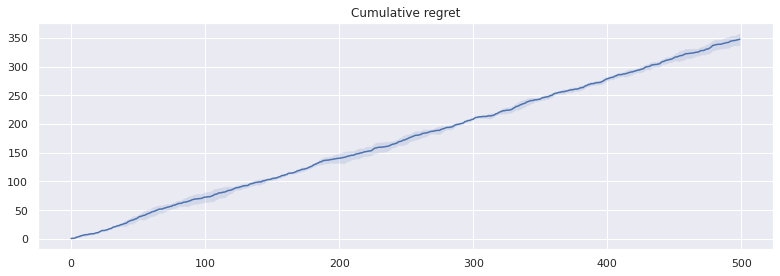

In [13]:
fig, ax = plt.subplots(figsize=(11, 4), nrows=1, ncols=1)

t = np.arange(T)

mean_regrets = np.mean(regrets, axis=0)
std_regrets = np.std(regrets, axis=0) / np.sqrt(regrets.shape[0])
ax.plot(t, mean_regrets)
ax.fill_between(t, mean_regrets - 2*std_regrets, mean_regrets + 2*std_regrets, alpha=0.15)
    
ax.set_title('Cumulative regret')

plt.tight_layout()
plt.show()

fig.savefig('figures/neural_ucb_cosine.pdf')